# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [3]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.0000006)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))

vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 36 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 28


## Apprentissage du modèle

In [8]:
LMtransformer = Transformer(vocab_size, nb_decoders, Decoder(MultiHeadAttention(nb_heads, head_size, vector_size), FeedforwardNetwork(vector_size, ffn_hidden_size)))

#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [9]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = tokens_numbers_sequences[batch_indices]
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / step))
                
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                
                running_loss = 0.
                
        plt.plot(epochs_losses, losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

C:\Users\Eric\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)


[1,     1] loss: 3.344
[1,     2] loss: 1.987
[1,     3] loss: 1.050
[1,     4] loss: 0.467
[1,     5] loss: 0.372
[2,     1] loss: 0.208
[2,     2] loss: 0.224
[2,     3] loss: 0.360
[2,     4] loss: 0.607
[2,     5] loss: 0.316
[3,     1] loss: 0.226
[3,     2] loss: 0.031
[3,     3] loss: 0.262
[3,     4] loss: 0.206
[3,     5] loss: 0.279
[4,     1] loss: 0.344
[4,     2] loss: 0.195
[4,     3] loss: 0.293
[4,     4] loss: 0.016
[4,     5] loss: 0.253
[5,     1] loss: 0.146
[5,     2] loss: 0.032
[5,     3] loss: 0.036
[5,     4] loss: 0.299
[5,     5] loss: 0.370
[6,     1] loss: 0.058
[6,     2] loss: 0.046
[6,     3] loss: 0.131
[6,     4] loss: 0.079
[6,     5] loss: 0.220
[7,     1] loss: 0.119
[7,     2] loss: 0.082
[7,     3] loss: 0.172
[7,     4] loss: 0.156
[7,     5] loss: 0.017
[8,     1] loss: 0.010
[8,     2] loss: 0.041
[8,     3] loss: 0.066
[8,     4] loss: 0.135
[8,     5] loss: 0.057
[9,     1] loss: 0.040
[9,     2] loss: 0.111
[9,     3] loss: 0.019
[9,     4] 

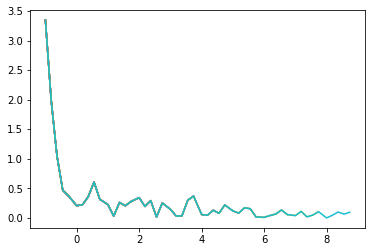

In [10]:
train_model(10,5)

## Génération

In [11]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    return np.exp(LMtransformer(torch.tensor([listints]))[0][-1].tolist())

In [12]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [13]:
def gen_seq_maison(prev_seq):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred))

In [14]:
gen_seq(['il'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 59.35it/s]


est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de 31 ans , il est touche par l ' age est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu


In [15]:
gen_seq(['a','l','age','de','31','ans'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 54.26it/s]


, a barcelone , il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il


In [16]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 55.87it/s]


' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir


In [17]:
if len(tokens)<100:
    print(' '.join(tokens))

a l ' age de 31 ans , a barcelone , il est touche par l ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d '
